In [22]:
from typing import List
import networkx as nx
import numpy as np
import pandas as pd
import datetime
from hatch import contributions_to_token_batches, TokenBatch, Commons

from cadCAD.configuration import Configuration


def initialize_network_of_hatchers(participants: List[TokenBatch]):
    """
    The role of this function is simply to fill up the directed graph.
    Helper functions setting up the tokens etc should be defined elsewhere
    and only provide values to this dumb function to put in the graph.
    """
    network = nx.DiGraph()
    for i, p in enumerate(participants):
        network.add_node(i)
        network.nodes[i]['type'] = "participant"
        network.nodes[i]['holdings_vesting'] = p
        network.nodes[i]['holdings_nonvesting'] = TokenBatch(0, 5, 5)  # just random numbers that don't mean anything if this is not a hatch token
        network.nodes[i]['sentiment'] = np.random.rand()
    
    return network


In [23]:
def sellout_asap(params, step, sL, s):
    network = s["network"]
    how_much_to_sell = []
    today = datetime.datetime.today()
    for i in network.nodes:
        node = network.nodes[i]
        token_batch = node["holdings_vesting"]
        token_batch.current_date = token_batch.creation_date + datetime.timedelta(days=s["timestep"])
        how_much_to_sell.append(node["holdings_vesting"].spendable())
    return {"update_network_spending": how_much_to_sell, "commons": None}

def update_network(params, step, sL, s, _input):
    network = s["network"]
    participants_expenditure = _input["update_network_spending"]
    for i in network.nodes:
        node = network.nodes[i]
        token_batch = node["holdings_vesting"]
        token_batch.current_date = token_batch.creation_date + datetime.timedelta(days=s["timestep"])
        token_batch.spend(participants_expenditure[i])
    return "network", network

def update_commons(params, step, sL, s, _input):
    commons = s["commons"]
    participants_expenditure = _input["update_network_spending"]
    for expenditure in participants_expenditure:
        if expenditure > 0:
            commons.burn(expenditure)
            s["funding_pool"] = commons._funding_pool
            s["collateral_pool"] = commons._collateral_pool
            s["token_supply"] = commons._token_supply
    return "commons", commons

In [24]:
contributions = [5e5, 5e5, 2.5e5]
token_batches, initial_token_supply = contributions_to_token_batches(contributions, 0.1, 60)

n = initialize_network_of_hatchers(token_batches)
commons = Commons(sum(contributions), initial_token_supply)
initial_conditions = {
    "network": n,
    "commons": commons,
    "funding_pool": commons._funding_pool,
    "collateral_pool": commons._collateral_pool,
    "token_supply": commons._token_supply
}

partial_state_update_blocks = [
    {
        "policies": {
            "sellout_asap": sellout_asap
        },
        "variables": {
            "network": update_network,
            "commons": update_commons,
        }
    },

]

In [25]:
simulation_parameters = {
    'T': range(150),
    'N': 1,
    'M': {}
}

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )


from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x7fe0ad4d3220>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7fe0ad4d3220>]


In [26]:
df = pd.DataFrame(raw_result)

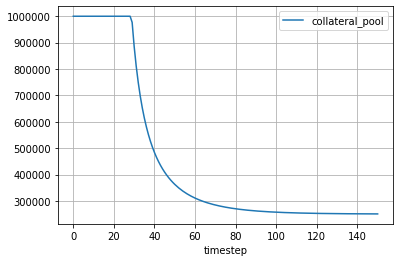

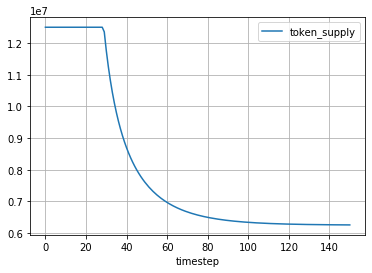

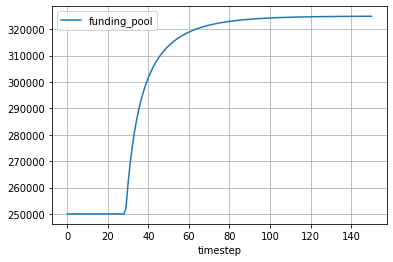

In [27]:
df.plot("timestep", "collateral_pool", grid=True)
df.plot("timestep", "token_supply", grid=True)
df.plot("timestep", "funding_pool", grid=True)